# CARE Denoising with the Tribolium Dataset using CAREamics

The Tribolium dataset is composed of noisy and GT high SNR images for training and testing. The dataset was acquired with fluorescence microscopy, originally used in Weigert et al (2018) to showcase CARE denoising. This notebook demostrates CARE denoising using the CAREamics library. 

In [3]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tifffile import imread
from careamics import CAREamist
from careamics.config import create_care_configuration
from careamics.utils.metrics import scale_invariant_psnr
from microssim import micro_structural_similarity

# Utility function for visualization
def visualize_images(img1, img2, title1="Low", title2="High", aspect='auto'):
    """
    Visualize two images side by side with consistent aspect ratio.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 10))
    ax[0].imshow(img1, aspect=aspect)
    ax[0].set_title(title1)
    ax[0].axis('off')
    
    ax[1].imshow(img2, aspect=aspect)
    ax[1].set_title(title2)
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()


## Load the training data

In [4]:
# Download and extract the dataset
import requests, zipfile, io

url = 'http://csbdeep.bioimagecomputing.com/example_data/tribolium.zip'

print("Downloading and extracting dataset...")
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall('data')
print("Dataset successfully downloaded and extracted to 'data'.")

# Future approach: Portfolio loading (currently commented out)
"""Need to fix dataset hash in portfolio, then switch to pooch import method"""
# from careamics_portfolio import PortfolioManager

# portfolio = PortfolioManager()
# files = portfolio.denoising.Tribolium.download()
# files.sort()


Dataset successfully downloaded and extracted to 'data'.


'Need to fix dataset hash in portfolio, then switch to pooch import method'

In [5]:
from tifffile import imread
from pathlib import Path

# Define paths to training and test data
train_low_path = Path('data/tribolium/train/low')
train_gt_path = Path('data/tribolium/train/GT')
test_low_path = Path('data/tribolium/test/low')
test_gt_path = Path('data/tribolium/test/GT')

# Inspect a single training and test image
train_low_sample = imread(sorted(train_low_path.glob('*.tif'))[0])
train_gt_sample = imread(sorted(train_gt_path.glob('*.tif'))[0])
test_low_sample = imread(sorted(test_low_path.glob('*.tif'))[0])
test_gt_sample = imread(sorted(test_gt_path.glob('*.tif'))[0])

print(f"\nTraining Data (Low SNR): Shape: {train_low_sample.shape}")
print(f"Training Data (Ground Truth): Shape: {train_gt_sample.shape}")
print(f"Test Data (Low SNR): Shape: {test_low_sample.shape}")
print(f"Test Data (Ground Truth): Shape: {test_gt_sample.shape}")


Training Data (Low SNR): Shape: (48, 773, 665)
Training Data (Ground Truth): Shape: (48, 773, 665)
Test Data (Low SNR): Shape: (45, 954, 486)
Test Data (Ground Truth): Shape: (45, 954, 486)


In [6]:
# Define paths to the low and ground truth images
low_snr_path = Path('data/tribolium/train/low')
gt_path = Path('data/tribolium/train/GT')

# Get sorted lists of files
low_snr_files = sorted(low_snr_path.glob('*.tif'))
gt_files = sorted(gt_path.glob('*.tif'))

print(f"Found {len(low_snr_files)} training image pairs.")


Found 1 training image pairs.


## Load the image pairs into arrays

In [7]:
# Load low SNR and ground truth images into NumPy arrays
X_images = np.array([imread(file) for file in low_snr_files]).squeeze() 
Y_images = np.array([imread(file) for file in gt_files]).squeeze() 

print(f"Training Data Shapes:")
print(f"X_images: {X_images.shape} (ZYX), Y_images: {Y_images.shape} (ZYX)")


Training Data Shapes:
X_images: (48, 773, 665) (ZYX), Y_images: (48, 773, 665) (ZYX)


## Visualize the training data

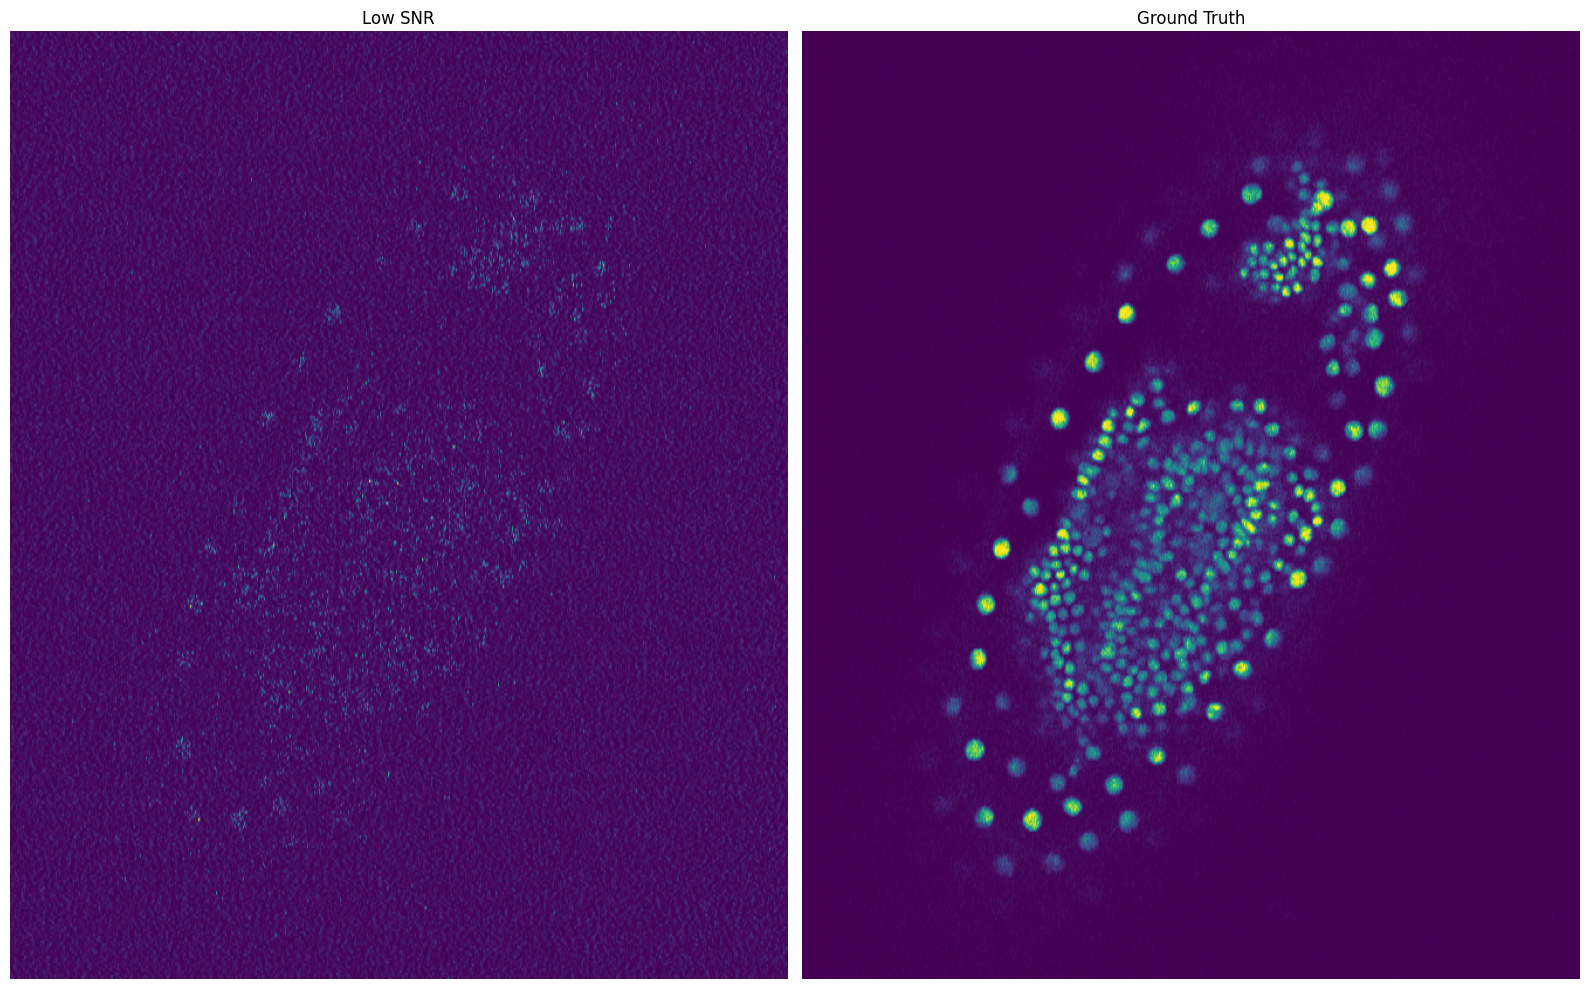

In [8]:
# Visualize a middle slice from the training data (3D ZYX)
slice_idx = X_images.shape[0] // 2  # Middle Z slice

# Extract the slice
low_img_slice = X_images[slice_idx, :, :]  # Correctly slice the middle Z-plane
gt_img_slice = Y_images[slice_idx, :, :]   # Correctly slice the middle Z-plane

# Visualize using the utility function
visualize_images(low_img_slice, gt_img_slice, title1="Low SNR", title2="Ground Truth")


Maximum intensity projections

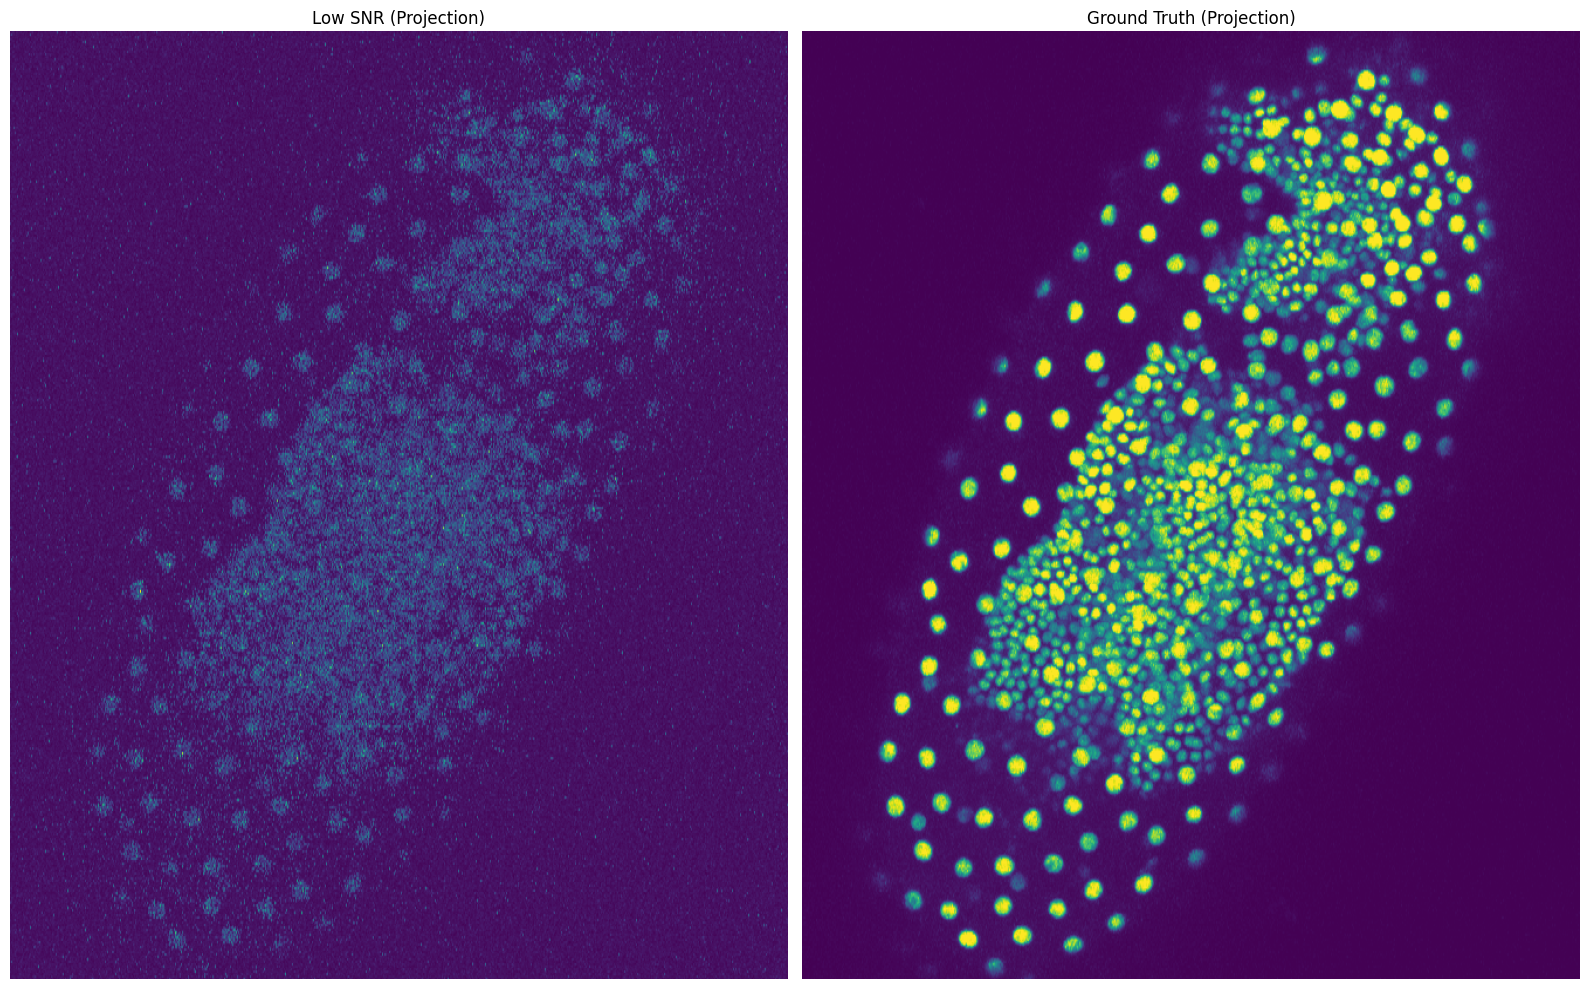

In [9]:
# Compute maximum intensity projections (MIPs) across the Z-axis
low_img_projection = np.max(X_images, axis=0)  # Max projection along the Z-axis
gt_img_projection = np.max(Y_images, axis=0)  # Max projection along the Z-axis

# Normalize the projections
def normalize_image(img):
    """Normalize an image to the range [0, 1]."""
    return (img - img.min()) / (img.max() - img.min())

low_img_projection_norm = normalize_image(low_img_projection)
gt_img_projection_norm = normalize_image(gt_img_projection)

# Visualize the projections
visualize_images(low_img_projection_norm, gt_img_projection_norm, title1="Low SNR (Projection)", title2="Ground Truth (Projection)")


## Configure CARE denoising model

In [10]:
# Create CARE configuration
config = create_care_configuration(
    experiment_name="CARE_Tribolium",
    data_type="array",
    axes="ZYX",  
    patch_size=(16, 64, 64), 
    batch_size=1,
    num_epochs=100,
    model_checkpoint={},
)

## Initialize and train the model

In [11]:
careamist = CAREamist(config)

careamist.train(
    train_source=X_images,
    train_target=Y_images,
    val_percentage=0.2,    # Use 20% of data for validation
    val_minimum_split=1,   # Minimum number of samples in validation set
)

No working directory provided. Using current working directory: /home/diya.srivastava/Desktop/repos/careamics-examples/applications/care/denoising/3D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Extracted 429 patches from input array.
Computed dataset mean: [7.94022998], std: [6.98370222]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 1.5 M  | train
---------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.094     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 3:   9%|▉         | 31/343 [00:00<00:03, 79.12it/s, train_loss_step=0.0277, val_loss=0.192, train_loss_epoch=0.199] 

Epoch 99: 100%|██████████| 343/343 [00:04<00:00, 70.26it/s, train_loss_step=0.11, val_loss=0.168, train_loss_epoch=0.126]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 343/343 [00:05<00:00, 68.34it/s, train_loss_step=0.11, val_loss=0.168, train_loss_epoch=0.126]


## Prediction with CAREamics

In [12]:
# Define test data paths if not already defined
test_low_snr_path = Path('data/tribolium/test/low')  # Adjust this path as needed
test_low_snr_files = sorted(test_low_snr_path.glob('*.tif'))

# Load the test data into a NumPy array
test_low_images = np.array([imread(file) for file in test_low_snr_files])

In [13]:
# Load and sort test data files
test_low_snr_files = sorted(test_low_snr_path.glob('*.tif'))
test_gt_files = sorted(test_gt_path.glob('*.tif'))

# Check if the number of test files matches
assert len(test_low_snr_files) == len(test_gt_files), "Mismatch in number of test low SNR and GT files"

# Load test images and remove unnecessary channel
test_low_images = np.array([imread(file) for file in test_low_snr_files]).squeeze()
test_gt_images = np.array([imread(file) for file in test_gt_files]).squeeze()

print(f"Test data shape: {test_low_images.shape} (ZYX), Training data shape: {X_images.shape} (ZYX)")
print(f"Loaded and verified {len(test_low_images)} test image pairs.")


Test data shape: (45, 954, 486) (ZYX), Training data shape: (48, 773, 665) (ZYX)
Loaded and verified 45 test image pairs.


In [14]:
# Perform prediction with the test data
predictions = careamist.predict(
    source=test_low_images, 
    data_type="array",
    axes="ZYX", 
    tile_size=(16, 64, 64),  
    tile_overlap=(8, 32, 32), 
    batch_size=1, 
    tta=False 
)

# Print confirmation
print(f"Prediction complete. Number of predicted images: {len(predictions)}")


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Prediction complete. Number of predicted images: 1


## Visualize Predictions vs Ground Truth

Test low images shape: (45, 954, 486) (ZYX)
Test GT images shape: (45, 954, 486) (ZYX)
Test predictions shape after squeezing: (45, 954, 486) (ZYX)


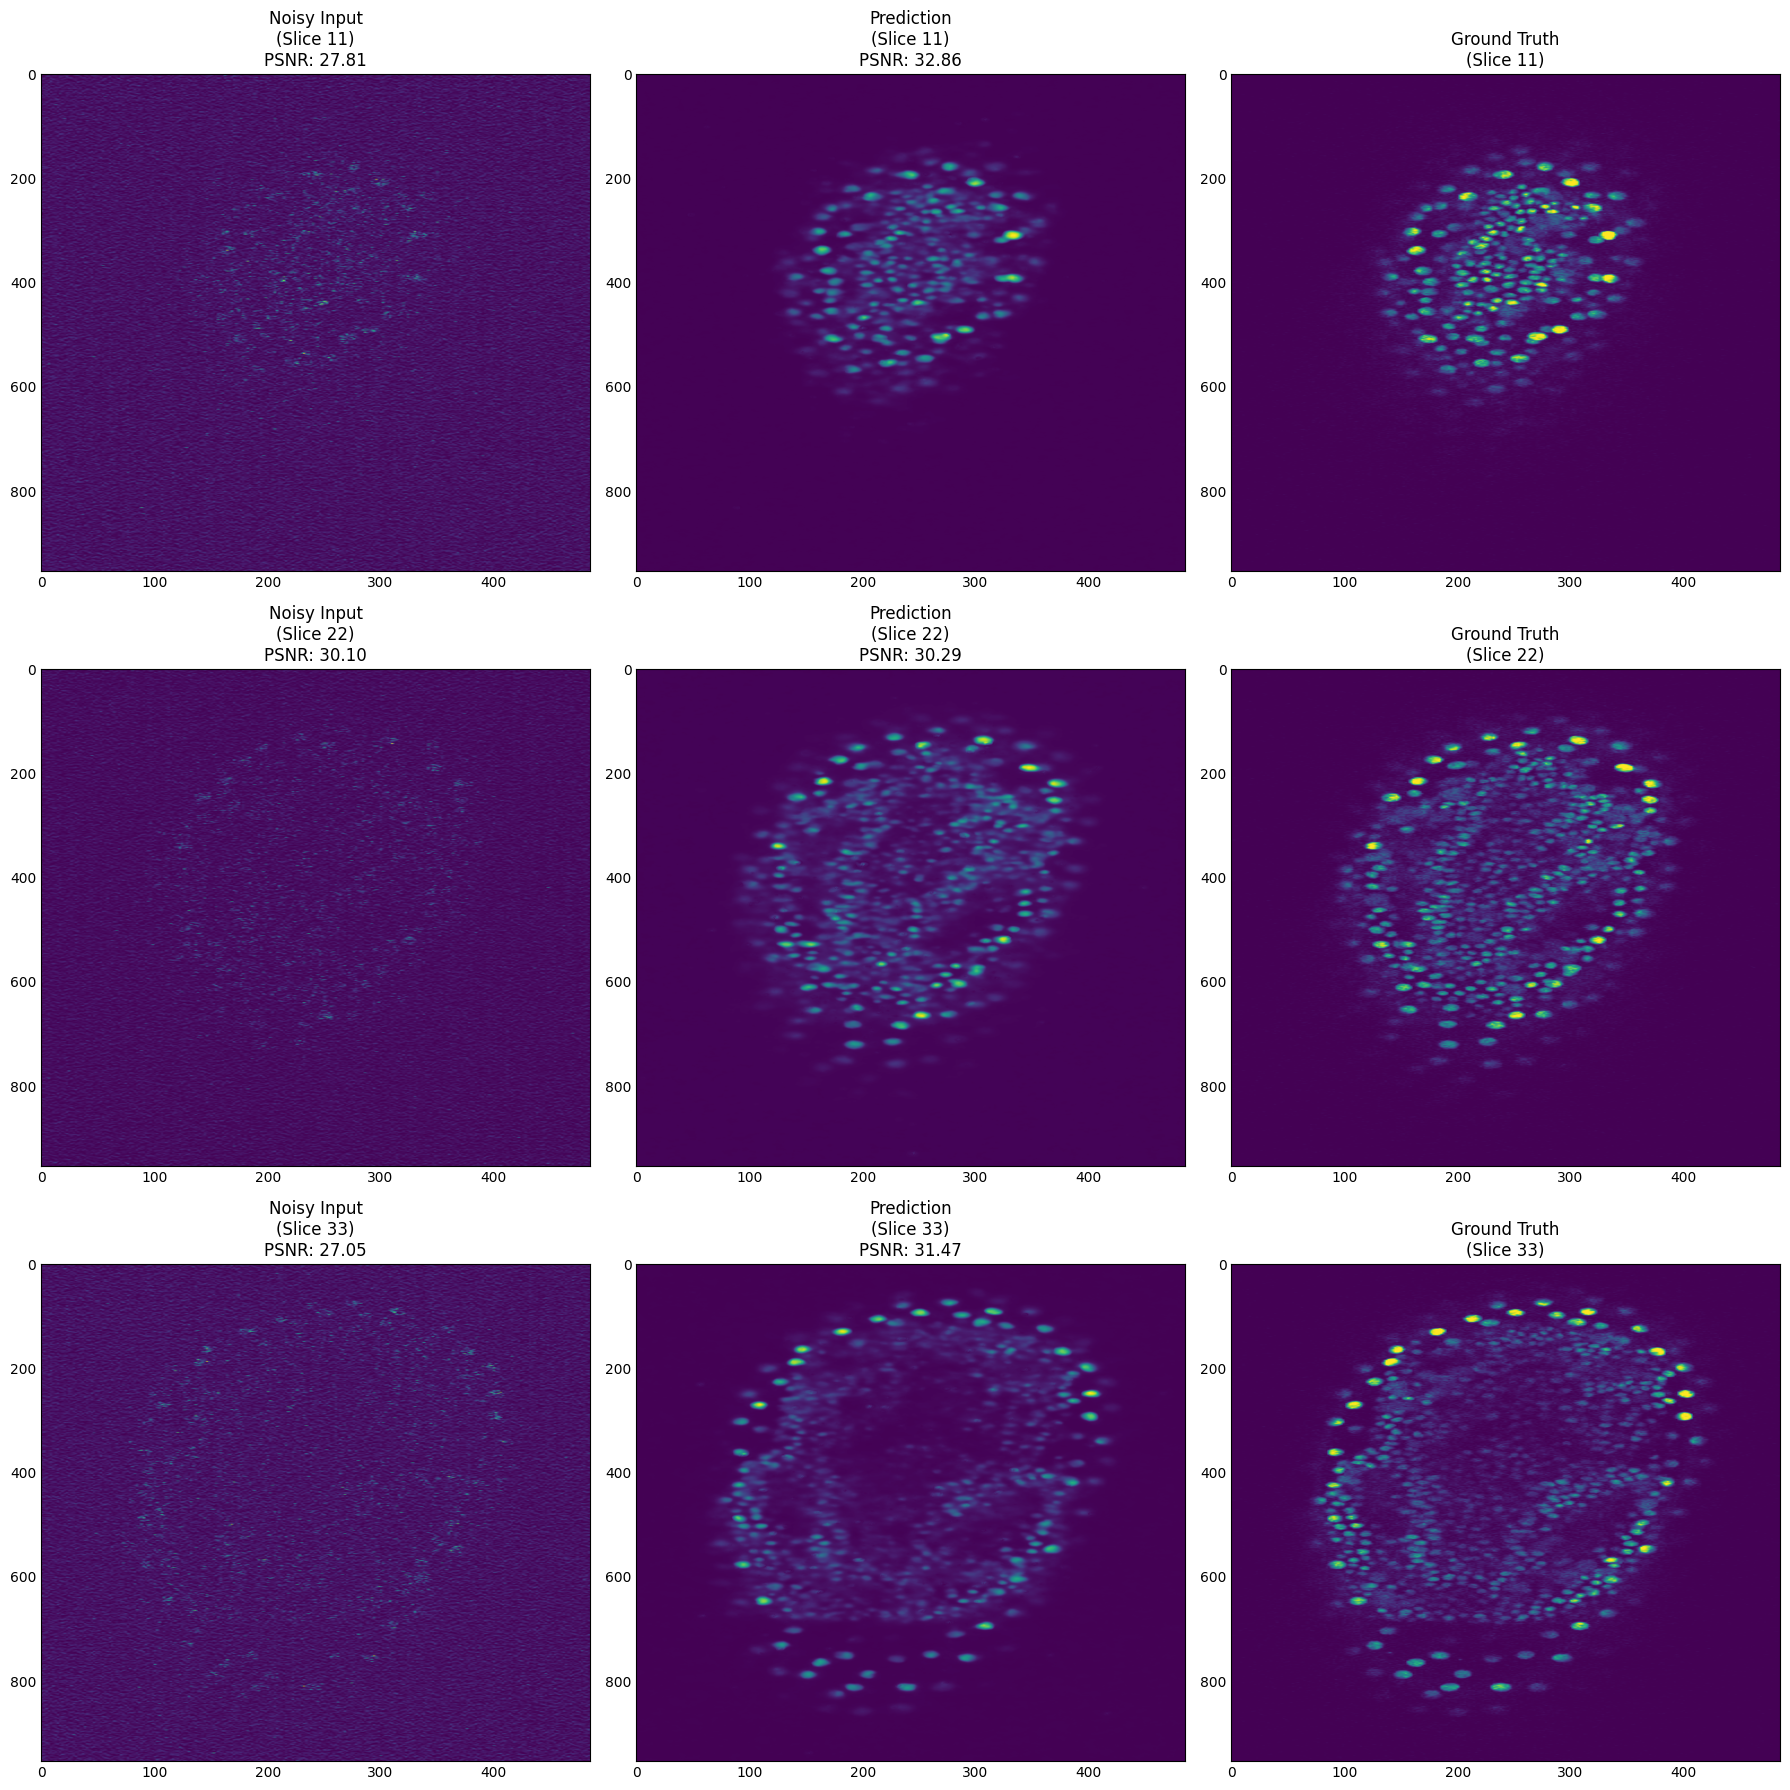

In [15]:
# Convert predictions to NumPy array and remove unnecessary dimensions
test_predictions = np.squeeze(np.array(predictions))

# Verify the shapes
print(f"Test low images shape: {test_low_images.shape} (ZYX)")
print(f"Test GT images shape: {test_gt_images.shape} (ZYX)")
print(f"Test predictions shape after squeezing: {test_predictions.shape} (ZYX)")

num_slices = test_low_images.shape[0]
slice_indices = [num_slices // 4, num_slices // 2, 3 * num_slices // 4]
fig, axes = plt.subplots(len(slice_indices), 3, figsize=(18, 6 * len(slice_indices)))

for row_idx, slice_idx in enumerate(slice_indices):
    # Extract slices
    noisy_slice = test_low_images[slice_idx].astype(np.float32)
    pred_slice = test_predictions[slice_idx].astype(np.float32)
    gt_slice = test_gt_images[slice_idx].astype(np.float32)

    # Compute PSNR
    psnr_noisy = scale_invariant_psnr(noisy_slice, gt_slice)
    psnr_pred = scale_invariant_psnr(pred_slice, gt_slice)

    # Plot slices
    for col_idx, (img, title) in enumerate([
        (noisy_slice, f"Noisy Input\n(Slice {slice_idx})\nPSNR: {psnr_noisy:.2f}"),
        (pred_slice, f"Prediction\n(Slice {slice_idx})\nPSNR: {psnr_pred:.2f}"),
        (gt_slice, f"Ground Truth\n(Slice {slice_idx})")
    ]):
        axes[row_idx, col_idx].imshow(img, aspect="auto")
        axes[row_idx, col_idx].set_title(title)
        axes[row_idx, col_idx].tick_params(axis="both", which="both", length=0) 

plt.tight_layout()
plt.show()


## Compute average PSNR and microSSIM over all slices

In [17]:
psnr_noisy_list = [
    scale_invariant_psnr(test_low_images[slice_idx], test_gt_images[slice_idx])
    for slice_idx in range(test_low_images.shape[0])
]

microssim_noisy_list = [
    micro_structural_similarity(test_low_images[slice_idx], test_gt_images[slice_idx])
    for slice_idx in range(test_low_images.shape[0])
]

# Compute PSNR and MicroSSIM for predictions across all slices
psnr_pred_list = [
    scale_invariant_psnr(test_predictions[slice_idx], test_gt_images[slice_idx])
    for slice_idx in range(test_predictions.shape[0])
]

microssim_pred_list = [
    micro_structural_similarity(test_predictions[slice_idx], test_gt_images[slice_idx])
    for slice_idx in range(test_predictions.shape[0])
]

# Calculate average values
average_psnr_noisy = np.mean(psnr_noisy_list)
average_psnr_pred = np.mean(psnr_pred_list)
average_microssim_noisy = np.mean(microssim_noisy_list)
average_microssim_pred = np.mean(microssim_pred_list)

# Print the results
print(f"Average PSNR of Noisy Input (Test Data): {average_psnr_noisy:.2f}")
print(f"Average PSNR of Prediction (Test Data): {average_psnr_pred:.2f}")
print(f"Average MicroSSIM of Noisy Input (Test Data): {average_microssim_noisy:.3f}")
print(f"Average MicroSSIM of Prediction (Test Data): {average_microssim_pred:.3f}")

/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/microssim/ssim/ssim_utils.py:297: RuntimeWarning: invalid value encountered in sqrt
  term = 2 * alpha * np.sqrt(elements.vx * elements.vy) + elements.C2
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/microssim/ssim/ssim_utils.py:297: RuntimeWarning: invalid value encountered in sqrt
  term = 2 * alpha * np.sqrt(elements.vx * elements.vy) + elements.C2


Average PSNR of Noisy Input (Test Data): 28.54
Average PSNR of Prediction (Test Data): 32.65
Average MicroSSIM of Noisy Input (Test Data): 0.237
Average MicroSSIM of Prediction (Test Data): 0.907


## Get Losses

While our dataset originally came with only training and testing sets, during the training process, we automatically split the training data into:

- Training set (80% of original training data): Used for actual model training
- Validation set (20% of original training data): Used to monitor performance

Let's look at the losses:

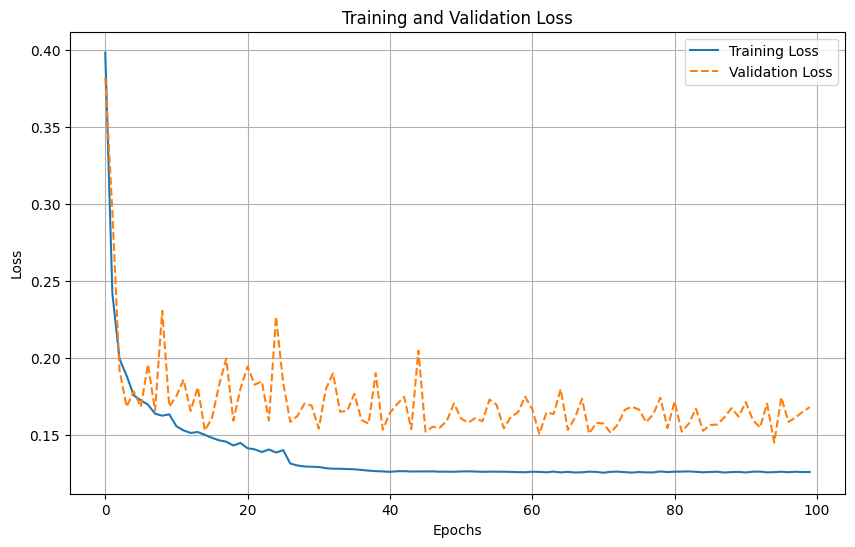

In [18]:
# Retrieve the training and validation losses from CAREamist
losses = careamist.get_losses()

# Extract train and validation losses and epochs with defaults
train_losses = losses.get('train_loss', [])
val_losses = losses.get('val_loss', [])
train_epochs = losses.get('train.epoch', list(range(len(train_losses))))
val_epochs = losses.get('val.epoch', list(range(len(val_losses))))

plt.figure(figsize=(10, 6))

if train_losses:
    plt.plot(train_epochs, train_losses, label='Training Loss')
else:
    print("No training data found.")

if val_losses:
    plt.plot(val_epochs, val_losses, label='Validation Loss', linestyle='--')
else:
    print("No validation data found.")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()


And you're done! 